In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy
from evaluation import *
from model_utils import *
from utils import *

In [198]:
COSTS = [0.1, 1.25, 4.]

df = pd.read_pickle('data/eval_envs.pkl')
label = Labeler()
df['env_id'] = df.env.apply(label)

In [199]:
def choose_envs(df, n=10):
    util = df.groupby('agent env_id'.split()).util.mean()
    std = df.groupby('agent env_id'.split()).util.std()
    advantage = util.BO - util.none
    loss = (advantage - advantage.mean()) ** 2
#     loss += 0.1 * (util.none - util.none.mean()) ** 2
    loss += (std  - std.mean(level='agent'))['BO'] ** 2
    return list(loss.sort_values()[:n].index)

chosen = df.groupby('cost').apply(choose_envs)

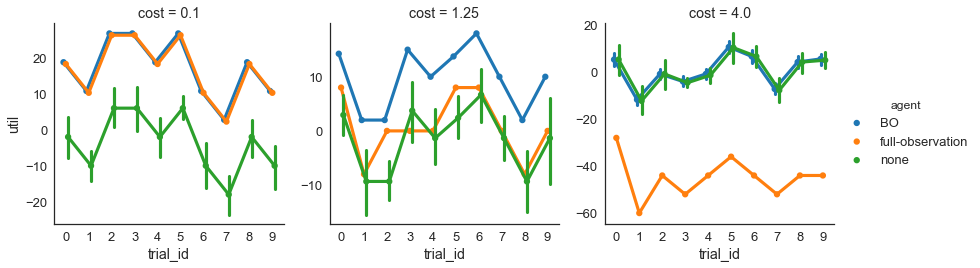

In [200]:
all_chosen = list(concat(chosen))
cdf = df.query('env_id == @all_chosen').copy()
trial_labs = {c: Labeler() for c in COSTS}
cdf['trial_id'] = cdf.apply(lambda x: trial_labs[x.cost](x.env_id), axis=1)

sns.factorplot('trial_id', 'util', hue='agent', col='cost',
               sharex=False, sharey=False, dodge=.2, markers='.', data=cdf)

In [201]:
chosen_envs = chosen.apply(lmap(label.unlabel))
chosen_envs.to_pickle('data/experimental_envs.pkl')

# Write experiment files

In [213]:
for cost, envs in chosen_envs.items():
    print(cost)

0.1
1.25
4.0


In [222]:
# Write rewards json files
for cost, envs in chosen_envs.items():
    result = []
    for i, env in enumerate(envs):
        result.append({
            'trial_id': i,
            'env_id': label(env),
            'objectQs': {str(move): env.true_Q(move) for move in env.tree[0]},
            'stateRewards': list(env.ground_truth),
        })
    fn = f'data/experiment/rewards{cost:.2f}.json'
    with open(fn, 'w+') as f:
        json.dump(list(trial_data()), f)
    print('wrote', fn)

[<mouselab.MouselabEnv object at 0x7f90179bdc18>, <mouselab.MouselabEnv object at 0x7f90158b1a20>, <mouselab.MouselabEnv object at 0x7f9011513908>, <mouselab.MouselabEnv object at 0x7f9013b2ac50>, <mouselab.MouselabEnv object at 0x7f901587f208>, <mouselab.MouselabEnv object at 0x7f902da92828>, <mouselab.MouselabEnv object at 0x7f9013d066a0>, <mouselab.MouselabEnv object at 0x7f901585f390>, <mouselab.MouselabEnv object at 0x7f901535f6d8>, <mouselab.MouselabEnv object at 0x7f9015435438>]
<MouselabEnv instance>
<MouselabEnv instance>
<MouselabEnv instance>
<MouselabEnv instance>
<MouselabEnv instance>
<MouselabEnv instance>
<MouselabEnv instance>
<MouselabEnv instance>
<MouselabEnv instance>
<MouselabEnv instance>


AttributeError: 'list' object has no attribute 'tree'

In [ ]:
reward_list = [{'stateRewards': list(env.ground_truth)} for env in stimuli_envs]

for i in range(16):
    reward_list[i]['trial_id'] = i

In [202]:
from model_utils import read_bo_policy

def optimal_trace(cost):
    agent = Agent()
    agent.register(read_bo_policy(cost))
    envs = make_envs(cost, n=16, ground_truth=1)
    for env in envs:
        agent.register(env)
        trace = agent.run_episode()

        clicks = [{'is_click': 1, 'state': a} for a in trace['actions']]
        moves = [{'is_click': 0, 'state': m} for m in env.best_path()]
        yield clicks + moves

for cost in [0.25, 1.0, 4.0]:
    with open(f'../experiments/exp1/static/json/optimal_policy_{cost:.2f}', 'w+') as f:
        json.dump(list(optimal_trace(cost)), f)

FileNotFoundError: [Errno 2] No such file or directory: '../experiments/exp1/static/json/optimal_policy_0.25'